In [1]:
# Running All Imports

import numpy as np
from numpy import ndarray
import matplotlib.pyplot as plt
%matplotlib inline
import sys
print(sys.version)


from qiskit import pulse, QuantumCircuit, ClassicalRegister#, IBMQ

from qiskit_ibm_runtime import QiskitRuntimeService

#from qiskit.tools.monitor import job_monitor

from qiskit.visualization.pulse_v2 import stylesheet

from scipy.optimize import curve_fit

from typing import Optional


# IBMQ.save_account("TOKEN", overwrite=True)
# Run previous line with the appropriate token
# service = QiskitRuntimeService(channel="ibm_cloud", token="TOKEN", instance="crn:v1:bluemix:public:quantum-computing:us-east:a/b500a23b61df4c36a9f1eef14a04227d:a6e2883a-5882-4f71-9942-1e480bb96768::")
service = QiskitRuntimeService()
print(service)

3.9.11 (v3.9.11:2de452f8bf, Mar 16 2022, 10:34:36) 
[Clang 6.0 (clang-600.0.57)]
<QiskitRuntimeService>


In [2]:
# provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
# provider.backends()
### SHERBROOKE DETAILS ###
backend = service.backend('ibm_sherbrooke') # replace the name with the exact one for the backend that is desired from the previous displayed backends
qubit = 0
print(backend)

<IBMBackend('ibm_sherbrooke')>


In [3]:
DEBUG_PRINT = True

backend_config = backend.configuration()
assert backend_config.open_pulse, "Backend doesn't support Pulse"

dt = backend_config.dt # Example way of getting data on the backend
backend_defaults = backend.defaults() 

acquire_alignment = backend.configuration().timing_constraints['acquire_alignment']
granularity = backend.configuration().timing_constraints['granularity']
pulse_alignment = backend.configuration().timing_constraints['pulse_alignment']

lcm = np.lcm(acquire_alignment, pulse_alignment)

# unit conversion factors -> all backend properties returned in SI (Hz, sec, etc.)
GHz = 1.0e9 # Gigahertz
MHz = 1.0e6 # Megahertz
us = 1.0e-6 # Microseconds
ns = 1.0e-9 # Nanoseconds

# Experiments will be run on these qubits
qubit_0 = 0
qubit_1 = 1

# The sweep will be centered around the estimated qubit frequency.
center_frequency_Hz_0 = backend_defaults.qubit_freq_est[qubit_0]
center_frequency_Hz_1 = backend_defaults.qubit_freq_est[qubit_1]

meas_freq_0 = backend_defaults.meas_freq_est[qubit_0]
meas_freq_1 = backend_defaults.meas_freq_est[qubit_1]

# scale factor to remove factors of 10 from the data
scale_factor = 1e-7

instruction_schedule_map = backend.defaults().instruction_schedule_map
measure_instructions = np.array(instruction_schedule_map.get("measure", qubits=[qubit]).instructions)
measure_pulse = measure_instructions[-2,1].pulse
measure_delay = measure_instructions[-1,1]

x_instructions = np.array(instruction_schedule_map.get("x", qubits=[qubit]).instructions)
x_pulse = x_instructions[0,1].pulse

sx_instructions = np.array(instruction_schedule_map.get("sx", qubits=[qubit]).instructions)
sx_pulse = sx_instructions[0,1].pulse

if DEBUG_PRINT:
    print(f"config: {backend_config}")

    for key, value in backend_config.to_dict().items():
        print(key)
        print(value)
    
    print(f"Sampling time: {dt*1e9} ns")    # The configuration returns dt in seconds, so multiply by
                                            # 1e9 to get nanoseconds

    backend_config.timing_constraints

    print(f"Least common multiple of acquire_alignment and pulse_alignment: {lcm}")

    print(f"Qubit {qubit_0} has an estimated frequency of {center_frequency_Hz_0 / GHz} GHz.")
    print(f"Qubit {qubit_1} has an estimated frequency of {center_frequency_Hz_1 / GHz} GHz.")

    print(f"Resonator for qubit {qubit_0} has an estimated frequency of {meas_freq_0 / GHz} GHz.")
    print(f"Resonator for qubit {qubit_1} has an estimated frequency of {meas_freq_1 / GHz} GHz.")

    print(f"measure_instructions: {measure_instructions}")

    print(f"measurement pulse: {measure_pulse}")
    print(f"measurement delay: {measure_delay}")
    print(f"x pulse: {x_pulse}")
    print(f"sx pulse: {sx_pulse}")

config: <qiskit.providers.models.backendconfiguration.PulseBackendConfiguration object at 0x7fbab2938e50>
backend_name
ibm_sherbrooke
backend_version
1.5.5
n_qubits
127
basis_gates
['ecr', 'id', 'rz', 'sx', 'x']
gates
[{'name': 'id', 'parameters': [], 'qasm_def': 'gate id q { U(0, 0, 0) q; }', 'coupling_map': [[0], [1], [2], [3], [4], [5], [6], [7], [8], [9], [10], [11], [12], [13], [14], [15], [16], [17], [18], [19], [20], [21], [22], [23], [24], [25], [26], [27], [28], [29], [30], [31], [32], [33], [34], [35], [36], [37], [38], [39], [40], [41], [42], [43], [44], [45], [46], [47], [48], [49], [50], [51], [52], [53], [54], [55], [56], [57], [58], [59], [60], [61], [62], [63], [64], [65], [66], [67], [68], [69], [70], [71], [72], [73], [74], [75], [76], [77], [78], [79], [80], [81], [82], [83], [84], [85], [86], [87], [88], [89], [90], [91], [92], [93], [94], [95], [96], [97], [98], [99], [100], [101], [102], [103], [104], [105], [106], [107], [108], [109], [110], [111], [112], [113], 

## Improved First Reset Tone Analysis
Running a Photon Measurement Experiment during a long first tone, trying to clarify if there's a latency or not

In [11]:
from utils import convert_arr_to_dt, get_dt_from

meas_times_us = np.array([10., 15., 20., 25., 30., 35., 40., 45., 50., 55.]) * ns
meas_times_us = convert_arr_to_dt(meas_times_us)

freq_span = 20.0 * MHz
freq_center = -2.5 * MHz
num_kappa_exps = 59
freq_linspace = np.linspace(-0.5 * freq_span, 0.5 * freq_span, num_kappa_exps) + freq_center

print(f"Freq Precision: {(freq_linspace[1] - freq_linspace[0]) / MHz}MHz")

print(meas_times_us / ns)

Freq Precision: 0.34482758620689624MHz
[10.66666667 14.22222222 21.33333333 24.88888889 28.44444444 35.55555556
 39.11111111 46.22222222 49.77777778 53.33333333]


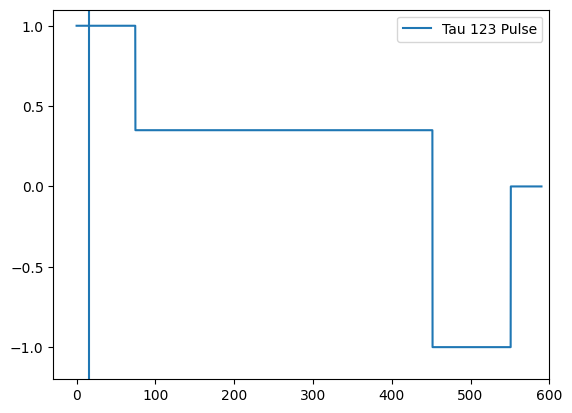

In [12]:
cal_tau_1 = 75 * ns
cal_tau_2 = 450 * ns
long_tau_3 = 100.0 * ns

meas_pulse_dur_dt = get_dt_from(cal_tau_2 + long_tau_3 + 40. * ns)

def get_tau_123_waveform(tau_1_dur_dt, tau_2_dur_dt, tau_3_dur_dt, total_dur_dt):
    t123_times = np.arange(total_dur_dt) * dt
    tau_123_pulse = measure_pulse.amp * np.heaviside(t123_times - tau_1_dur_dt * dt, 1.) * np.heaviside(tau_2_dur_dt * dt - t123_times, 1.)
    tau_123_pulse += np.heaviside(tau_1_dur_dt * dt - t123_times, 0.) # add tau 1 ring-up
    tau_123_pulse -= np.heaviside((tau_2_dur_dt + tau_3_dur_dt) * dt - t123_times, 0.) * np.heaviside(t123_times - (tau_2_dur_dt) * dt, 0.)
    return tau_123_pulse

tau_123_pulse = get_tau_123_waveform(
    get_dt_from(cal_tau_1, dt), 
    get_dt_from(cal_tau_2, dt),
    get_dt_from(long_tau_3, dt),
    meas_pulse_dur_dt
)

t_plot = np.arange(len(tau_123_pulse)) * dt / ns
plt.plot(t_plot, tau_123_pulse, label='Tau 123 Pulse')
plt.axvline(x=16)
plt.ylim(bottom=-1.2)
plt.xlim(right=600)
plt.legend()
plt.show()

590


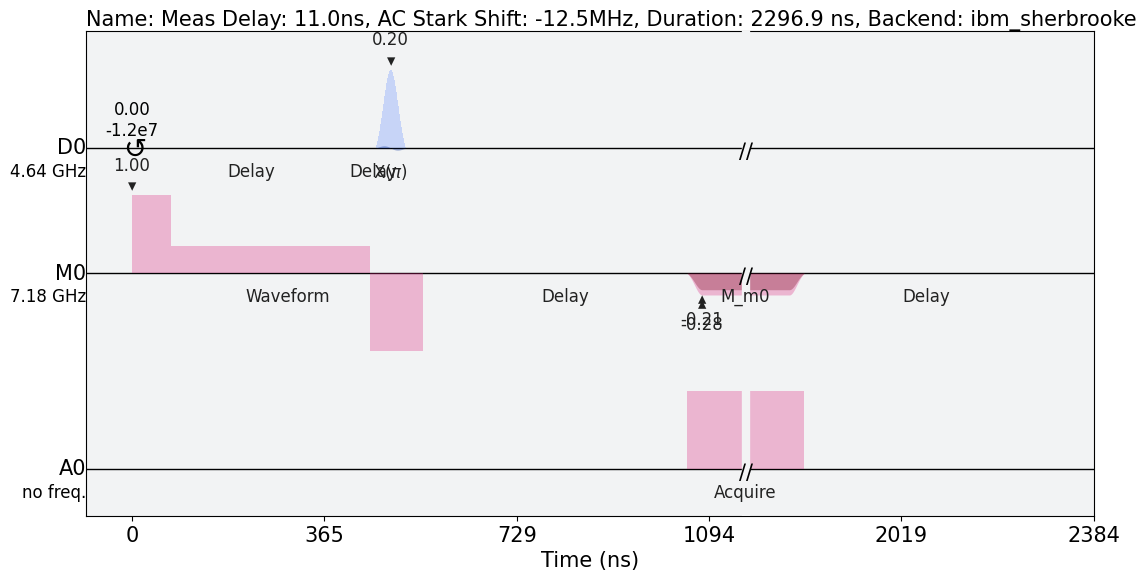

In [14]:
meas_exps = []

tau_3_pulse = tau_123_pulse = get_tau_123_waveform(
    get_dt_from(cal_tau_1, dt), 
    get_dt_from(cal_tau_2, dt),
    get_dt_from(long_tau_3, dt),
    meas_pulse_dur_dt
)

for meas_time_us in meas_times_us:
    meas_time_dt = get_dt_from(meas_time_us)
    
    for stark_shift_freq in freq_linspace:
        with pulse.build(
            backend=backend,
            default_alignment='sequential',
            name=f'Meas Delay: {np.round(meas_time_dt*dt/ns)}ns, AC Stark Shift: {np.round(stark_shift_freq/MHz, 3)}MHz'
        ) as meas_ac_stark_shift:
            qubit_chan = pulse.drive_channel(qubit)
            meas_chan = pulse.measure_channel(qubit)

            pulse.shift_frequency(stark_shift_freq, qubit_chan) # Shift Qubit Chan Frequency
            with pulse.align_left():
                pulse.play(tau_3_pulse, meas_chan) # Play Measure Pulse
                pulse.delay(get_dt_from(cal_tau_2), qubit_chan)
                pulse.delay(meas_time_dt, qubit_chan)
                pulse.play(x_pulse, qubit_chan) # Play Sharp Qubit Tone (X-Pulse)
                pulse.delay(measure_delay.duration, meas_chan)
            pulse.measure(qubit, pulse.MemorySlot(qubit))
        meas_exps.append(meas_ac_stark_shift)

print(len(meas_exps))

meas_exps[0].draw(
    backend=backend,
    style=stylesheet.IQXDebugging(),
    show_framechange=True,
    show_waveform_info=True,
    show_barrier=True,
)

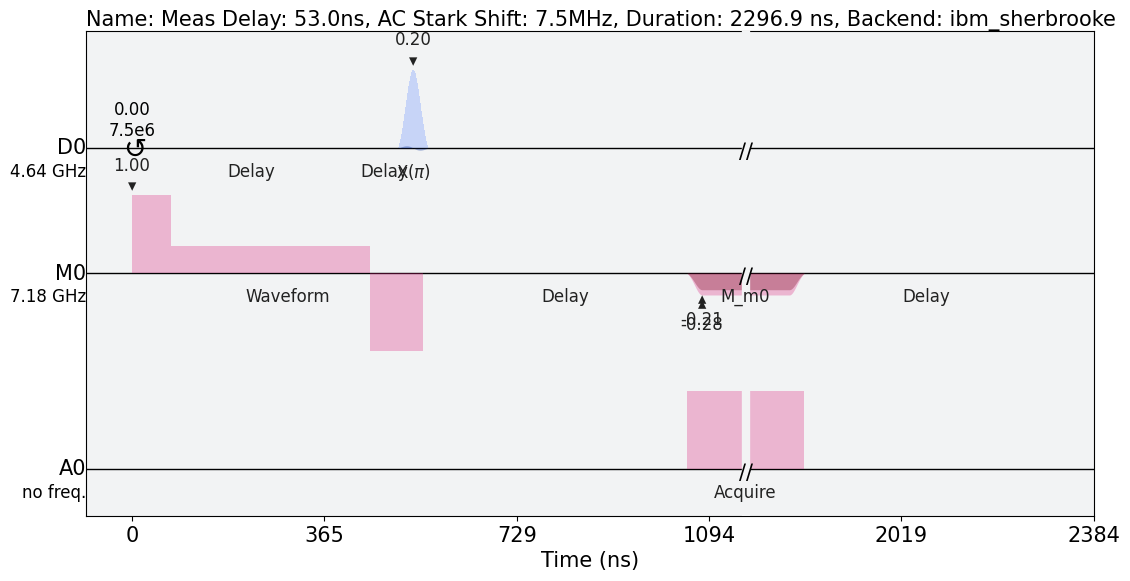

In [15]:
meas_exps[-1].draw(
    backend=backend,
    style=stylesheet.IQXDebugging(),
    show_framechange=True,
    show_waveform_info=True,
    show_barrier=True,
)

295
295


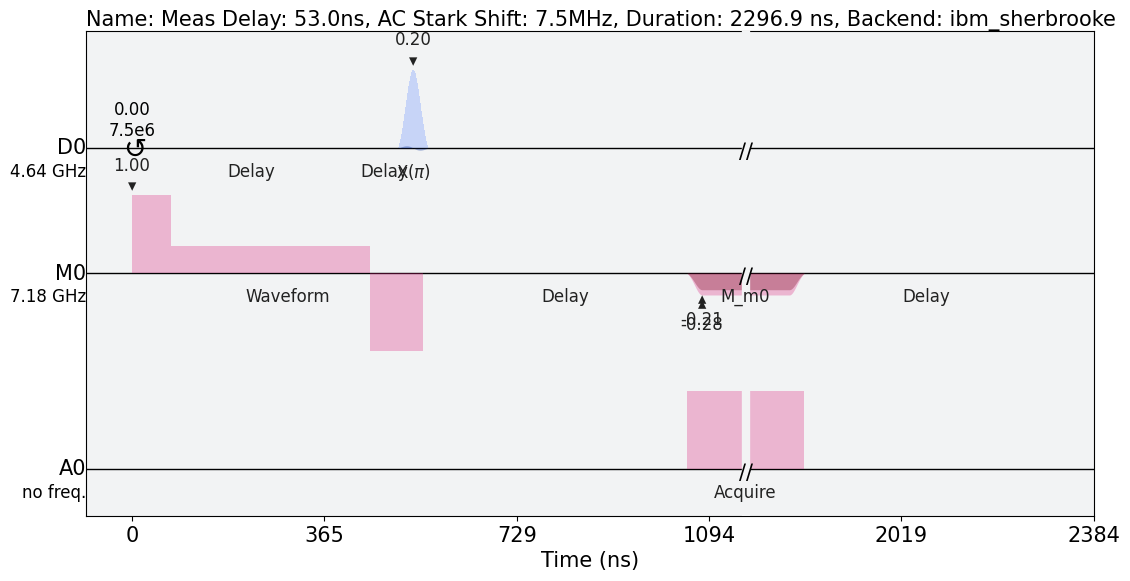

In [17]:
from utils import acquisition_checker

acquisition_checker(meas_exps, backend)

big_exps_arr = np.array(meas_exps).reshape(2, -1)
big_exp_1, big_exp_2 = big_exps_arr.tolist()

print(len(big_exp_1))
print(len(big_exp_2))

num_shots = 4096
rep_delay = 1. * us

big_exp_2[-1].draw(
    backend=backend,
    style=stylesheet.IQXDebugging(),
    show_framechange=True,
    show_waveform_info=True,
    show_barrier=True,
)

In [ ]:
# Running total_job

job_experiment = backend.run(big_exp_1, 
                            meas_level=1, 
                            meas_return='single', 
                            shots=num_shots,
                            rep_delay=rep_delay)

In [ ]:
# Running total_job

job_experiment = backend.run(big_exp_2, 
                            meas_level=1, 
                            meas_return='single', 
                            shots=num_shots,
                            rep_delay=rep_delay)